In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv('/Users/dhirkatre/code/movie-recommender/data/raw/movies.csv')
ratings = pd.read_csv('/Users/dhirkatre/code/movie-recommender/data/raw/ratings.csv')
tags = pd.read_csv('/Users/dhirkatre/code/movie-recommender/data/raw/tags.csv')
links = pd.read_csv('/Users/dhirkatre/code/movie-recommender/data/raw/links.csv')

print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Links shape:", links.shape)
print("Tags shape:", tags.shape)

# Quick look
display(movies.head())
display(ratings.head())
display(links.head().dropna())

Movies shape: (9742, 3)
Ratings shape: (100836, 4)
Links shape: (9742, 3)
Tags shape: (3683, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
n_users = ratings['userId'].nunique()
n_movies = movies['movieId'].nunique()
n_ratings = len(ratings)
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"Users: {n_users}, Movies: {n_movies}, Ratings: {n_ratings}")
print(f"Sparsity: {sparsity:.4%}")

Users: 610, Movies: 9742, Ratings: 100836
Sparsity: 98.3032%


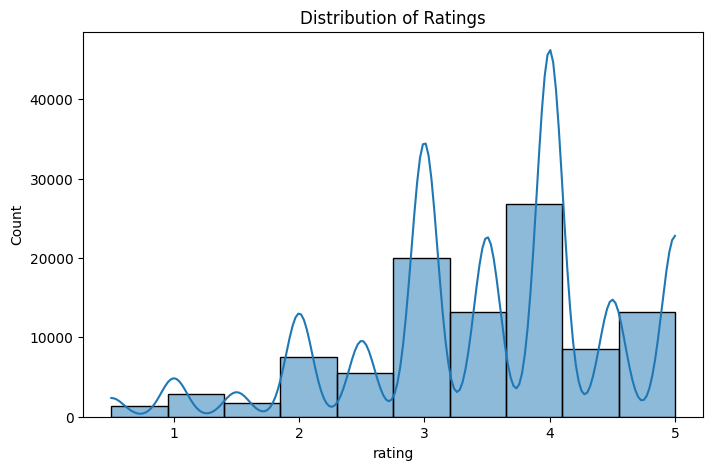

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.show()

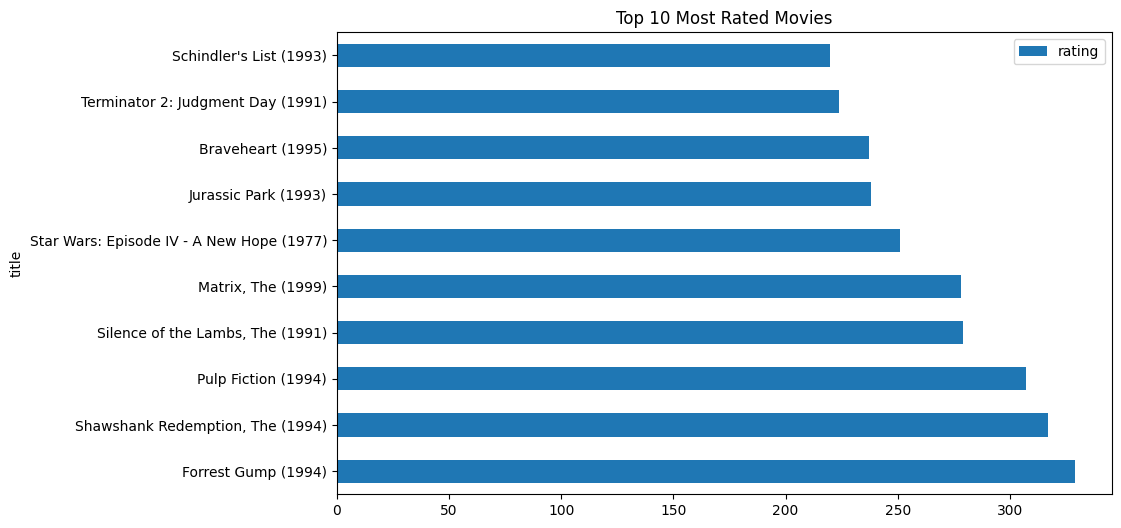

In [5]:
top_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
top_movies_titles = pd.merge(top_movies, movies, on='movieId')[['title', 'rating']]
top_movies_titles.plot(kind='barh', x='title', y='rating', figsize=(10,6))
plt.title('Top 10 Most Rated Movies')
plt.show()

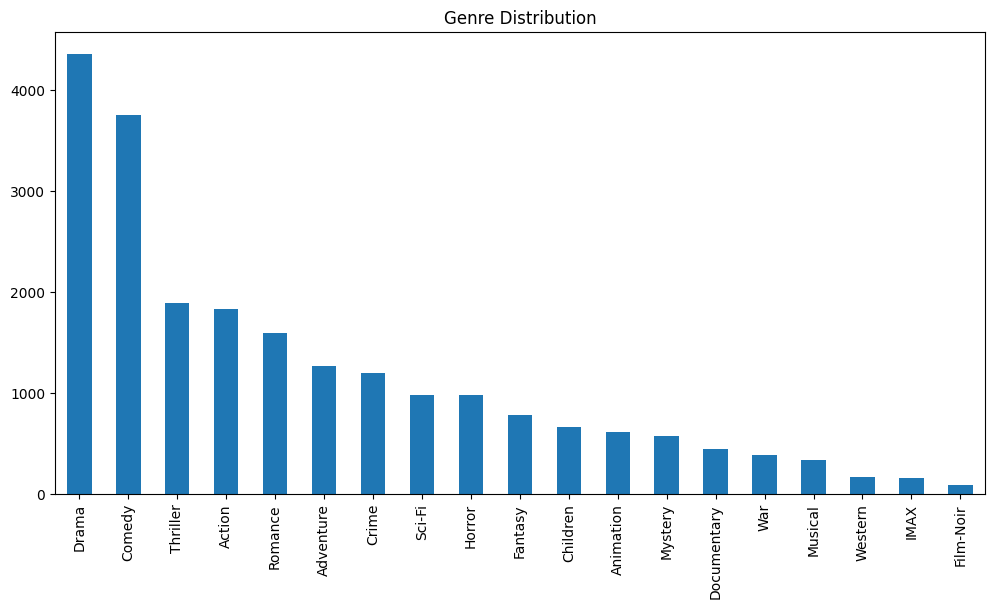

In [6]:
movies['genres_list'] = movies['genres'].str.split('|')
all_genres = [genre for sublist in movies['genres_list'] for genre in sublist if genre != '(no genres listed)']
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution')
plt.show()

In [7]:
movies_with_links = pd.merge(movies, links[['movieId', 'tmdbId']], on='movieId', how='left')
print("Missing tmdbId:", movies_with_links['tmdbId'].isna().sum())

Missing tmdbId: 8


In [8]:
movies_with_links = movies_with_links.dropna(subset=['tmdbId'])
print("After drop:", movies_with_links.shape)

After drop: (9734, 5)


In [13]:
# ──────────────────────────────────────────────────────────────
# Cell 1: Imports & load environment variables
# ──────────────────────────────────────────────────────────────

import pandas as pd
import requests
import time
from tqdm import tqdm
from dotenv import load_dotenv
import os

# Load .env file (must be in project root)
load_dotenv()

TMDB_KEY = os.getenv("TMDB_API_KEY")

if not TMDB_KEY:
    raise ValueError(
        "TMDB_API_KEY not found in .env file!\n"
        "Please create .env in project root with: TMDB_API_KEY=your_key_here"
    )

print("TMDB API key loaded successfully (not shown for security)")

# ──────────────────────────────────────────────────────────────
# Cell 2: Load merged data (run after your earlier merge step)
# ──────────────────────────────────────────────────────────────

# Assuming you already have this from previous cells
# movies_with_links = pd.merge(movies, links[['movieId', 'tmdbId']], on='movieId', how='left')

# Drop rows with missing tmdbId (only ~8 rows)
movies_with_links = movies_with_links.dropna(subset=['tmdbId']).copy()
print(f"After dropping missing tmdbId: {movies_with_links.shape[0]} movies")

# Make sure tmdbId is integer
movies_with_links['tmdbId'] = movies_with_links['tmdbId'].astype(int)

# ──────────────────────────────────────────────────────────────
# Cell 3: Fetch function + main loop
# ──────────────────────────────────────────────────────────────

BASE_URL = "https://api.themoviedb.org/3/movie/"

def get_movie_overview(tmdb_id: int) -> str | None:
    """
    Fetch overview/plot for a single movie from TMDB.
    Returns None or empty string on failure.
    """
    url = f"{BASE_URL}{tmdb_id}?api_key={TMDB_KEY}&language=en-US"
    
    for attempt in range(3):  # retry up to 3 times
        try:
            response = requests.get(url, timeout=12)
            
            if response.status_code == 200:
                data = response.json()
                overview = data.get('overview', '').strip()
                return overview if overview else "No plot summary available."
            
            elif response.status_code == 429:  # rate limit
                print(f"Rate limited (429) – sleeping 10 seconds...")
                time.sleep(10)
                continue  # retry
            
            else:
                print(f"Error {response.status_code} for tmdbId {tmdb_id}")
                return None
                
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {tmdb_id}: {e}")
            time.sleep(2 ** attempt)  # exponential backoff
            continue
    
    print(f"Failed after 3 attempts for tmdbId {tmdb_id}")
    return None


# ──────────────────────────────────────────────────────────────
# Apply fetch with progress bar
# ──────────────────────────────────────────────────────────────

print("Starting TMDB overview fetch...")

# Add column if not exists
if 'overview' not in movies_with_links.columns:
    movies_with_links['overview'] = pd.NA

tqdm.pandas(desc="Fetching overviews")
movies_with_links['overview'] = movies_with_links['tmdbId'].progress_apply(get_movie_overview)

# Fill any remaining NaN
movies_with_links['overview'] = movies_with_links['overview'].fillna("No plot summary available.")

# Quick quality check
print("\nSample results:")
print(movies_with_links[['title', 'tmdbId', 'overview']].sample(5))

# Save intermediate result (very useful!)
intermediate_path = '../data/processed/movies_with_plots_partial.csv'
movies_with_links.to_csv(intermediate_path, index=False)
print(f"Intermediate save: {intermediate_path}")

# ──────────────────────────────────────────────────────────────
# Cell 4: Final preprocessing & save
# ──────────────────────────────────────────────────────────────

# Optional: clean title (remove year if you prefer)
movies_with_links['title_clean'] = movies_with_links['title'].str.replace(
    r'\s*\(\d{4}\)$', '', regex=True
).str.strip()

# Final save
processed_path = '../data/processed/movies_with_plots.csv'
movies_with_links.to_csv(processed_path, index=False, encoding='utf-8')
print(f"Final enriched dataset saved to: {processed_path}")

print(f"Done! Dataset shape: {movies_with_links.shape}")
print(f"Missing overviews: {movies_with_links['overview'].str.strip().eq('').sum()}")

TMDB API key loaded successfully (not shown for security)
After dropping missing tmdbId: 9734 movies
Starting TMDB overview fetch...


Fetching overviews:  32%|██████████████████████████                                                       | 3126/9734 [08:44<17:33,  6.27it/s]

Error 404 for tmdbId 12773


Fetching overviews:  35%|███████████████████████████▉                                                     | 3361/9734 [09:24<16:49,  6.31it/s]

Error 404 for tmdbId 17882


Fetching overviews:  38%|██████████████████████████████▌                                                  | 3679/9734 [10:16<15:40,  6.44it/s]

Error 404 for tmdbId 68149


Fetching overviews:  38%|███████████████████████████████                                                  | 3740/9734 [10:26<16:02,  6.23it/s]

Error 404 for tmdbId 24549


Fetching overviews:  51%|█████████████████████████████████████████▍                                       | 4980/9734 [14:06<13:05,  6.05it/s]

Error 404 for tmdbId 14980


Fetching overviews:  51%|█████████████████████████████████████████▍                                       | 4985/9734 [14:07<12:56,  6.12it/s]

Error 404 for tmdbId 164721


Fetching overviews:  51%|█████████████████████████████████████████▋                                       | 5010/9734 [14:11<13:25,  5.86it/s]

Error 404 for tmdbId 140207


Fetching overviews:  52%|█████████████████████████████████████████▉                                       | 5035/9734 [14:15<13:34,  5.77it/s]

Error 404 for tmdbId 192936
Error 404 for tmdbId 876


Fetching overviews:  57%|█████████████████████████████████████████████▊                                   | 5507/9734 [15:42<12:12,  5.77it/s]

Error 404 for tmdbId 149645


Fetching overviews:  57%|██████████████████████████████████████████████                                   | 5537/9734 [15:48<11:14,  6.22it/s]

Error 404 for tmdbId 8677


Fetching overviews:  57%|██████████████████████████████████████████████▏                                  | 5543/9734 [15:48<11:18,  6.18it/s]

Error 404 for tmdbId 13057


Fetching overviews:  57%|██████████████████████████████████████████████▏                                  | 5549/9734 [15:50<11:39,  5.99it/s]

Error 404 for tmdbId 2670


Fetching overviews:  57%|██████████████████████████████████████████████▎                                  | 5567/9734 [15:52<11:08,  6.23it/s]

Error 404 for tmdbId 215993


Fetching overviews:  57%|██████████████████████████████████████████████▍                                  | 5584/9734 [15:55<12:34,  5.50it/s]

Error 404 for tmdbId 13519


Fetching overviews:  57%|██████████████████████████████████████████████▌                                  | 5591/9734 [15:57<11:51,  5.83it/s]

Error 404 for tmdbId 152426


Fetching overviews:  58%|██████████████████████████████████████████████▋                                  | 5604/9734 [15:59<13:20,  5.16it/s]

Error 404 for tmdbId 30983


Fetching overviews:  58%|██████████████████████████████████████████████▋                                  | 5611/9734 [16:00<12:16,  5.60it/s]

Error 404 for tmdbId 7096


Fetching overviews:  58%|██████████████████████████████████████████████▊                                  | 5625/9734 [16:03<10:48,  6.34it/s]

Error 404 for tmdbId 110147


Fetching overviews:  58%|███████████████████████████████████████████████                                  | 5661/9734 [16:09<11:08,  6.09it/s]

Error 404 for tmdbId 206216


Fetching overviews:  58%|███████████████████████████████████████████████▏                                 | 5678/9734 [16:12<11:57,  5.65it/s]

Error 404 for tmdbId 19341


Fetching overviews:  58%|███████████████████████████████████████████████▎                                 | 5688/9734 [16:14<11:47,  5.72it/s]

Error 404 for tmdbId 36763


Fetching overviews:  59%|███████████████████████████████████████████████▉                                 | 5764/9734 [16:27<10:38,  6.21it/s]

Error 404 for tmdbId 13716


Fetching overviews:  62%|██████████████████████████████████████████████████                               | 6016/9734 [17:12<11:16,  5.50it/s]

Error 404 for tmdbId 10700


Fetching overviews:  65%|████████████████████████████████████████████████████▉                            | 6366/9734 [18:22<11:35,  4.85it/s]

Error 404 for tmdbId 58923


Fetching overviews:  66%|█████████████████████████████████████████████████████▎                           | 6406/9734 [18:31<11:13,  4.94it/s]

Error 404 for tmdbId 17266


Fetching overviews:  66%|█████████████████████████████████████████████████████▋                           | 6448/9734 [18:40<11:43,  4.67it/s]

Error 404 for tmdbId 253768


Fetching overviews:  67%|██████████████████████████████████████████████████████▏                          | 6509/9734 [18:53<09:58,  5.39it/s]

Error 404 for tmdbId 49870


Fetching overviews:  68%|██████████████████████████████████████████████████████▋                          | 6572/9734 [19:06<08:56,  5.89it/s]

Error 404 for tmdbId 244797


Fetching overviews:  69%|███████████████████████████████████████████████████████▌                         | 6673/9734 [19:23<09:49,  5.19it/s]

Error 404 for tmdbId 53094


Fetching overviews:  70%|████████████████████████████████████████████████████████▉                        | 6838/9734 [19:50<08:17,  5.83it/s]

Error 404 for tmdbId 118309


Fetching overviews:  70%|█████████████████████████████████████████████████████████                        | 6855/9734 [19:53<08:07,  5.91it/s]

Error 404 for tmdbId 225130


Fetching overviews:  71%|█████████████████████████████████████████████████████████▏                       | 6876/9734 [19:57<07:56,  6.00it/s]

Error 404 for tmdbId 114796


Fetching overviews:  71%|█████████████████████████████████████████████████████████▎                       | 6890/9734 [19:59<08:36,  5.51it/s]

Error 404 for tmdbId 13905


Fetching overviews:  71%|█████████████████████████████████████████████████████████▍                       | 6908/9734 [20:02<08:06,  5.80it/s]

Error 404 for tmdbId 12224


Fetching overviews:  71%|█████████████████████████████████████████████████████████▋                       | 6934/9734 [20:06<07:33,  6.17it/s]

Error 404 for tmdbId 51247


Fetching overviews:  71%|█████████████████████████████████████████████████████████▊                       | 6942/9734 [20:08<08:12,  5.67it/s]

Error 404 for tmdbId 9795


Fetching overviews:  72%|██████████████████████████████████████████████████████████                       | 6974/9734 [20:13<07:52,  5.84it/s]

Error 404 for tmdbId 18884


Fetching overviews:  72%|██████████████████████████████████████████████████████████                       | 6981/9734 [20:14<07:31,  6.10it/s]

Error 404 for tmdbId 14301


Fetching overviews:  73%|██████████████████████████████████████████████████████████▋                      | 7059/9734 [20:27<07:10,  6.21it/s]

Error 404 for tmdbId 62128


Fetching overviews:  73%|██████████████████████████████████████████████████████████▊                      | 7075/9734 [20:30<07:25,  5.97it/s]

Error 404 for tmdbId 67479


Fetching overviews:  73%|███████████████████████████████████████████████████████████                      | 7095/9734 [20:33<07:29,  5.88it/s]

Error 404 for tmdbId 19422


Fetching overviews:  73%|███████████████████████████████████████████████████████████▎                     | 7123/9734 [20:38<07:10,  6.06it/s]

Error 404 for tmdbId 17632


Fetching overviews:  74%|███████████████████████████████████████████████████████████▉                     | 7207/9734 [20:52<06:49,  6.18it/s]

Error 404 for tmdbId 61872


Fetching overviews:  75%|████████████████████████████████████████████████████████████▊                    | 7309/9734 [21:09<06:30,  6.21it/s]

Error 404 for tmdbId 141714


Fetching overviews:  77%|██████████████████████████████████████████████████████████████▋                  | 7531/9734 [21:45<06:22,  5.76it/s]

Error 404 for tmdbId 183894


Fetching overviews:  78%|██████████████████████████████████████████████████████████████▉                  | 7563/9734 [21:51<06:02,  5.99it/s]

Error 404 for tmdbId 110639


Fetching overviews:  78%|███████████████████████████████████████████████████████████████                  | 7576/9734 [21:53<06:01,  5.97it/s]

Error 404 for tmdbId 367647


Fetching overviews:  78%|███████████████████████████████████████████████████████████████▏                 | 7589/9734 [21:55<05:31,  6.46it/s]

Error 404 for tmdbId 202241


Fetching overviews:  79%|████████████████████████████████████████████████████████████████▎                | 7727/9734 [22:18<05:34,  5.99it/s]

Error 404 for tmdbId 58423


Fetching overviews:  79%|████████████████████████████████████████████████████████████████▎                | 7735/9734 [22:20<05:38,  5.91it/s]

Error 404 for tmdbId 75964


Fetching overviews:  80%|████████████████████████████████████████████████████████████████▍                | 7740/9734 [22:21<05:42,  5.82it/s]

Error 404 for tmdbId 94174


Fetching overviews:  80%|████████████████████████████████████████████████████████████████▉                | 7806/9734 [22:32<05:18,  6.05it/s]

Error 404 for tmdbId 192695


Fetching overviews:  80%|█████████████████████████████████████████████████████████████████                | 7821/9734 [22:34<05:23,  5.91it/s]

Error 404 for tmdbId 54507
Error 404 for tmdbId 59017


Fetching overviews:  80%|█████████████████████████████████████████████████████████████████                | 7824/9734 [22:35<05:28,  5.82it/s]

Error 404 for tmdbId 26397


Fetching overviews:  81%|█████████████████████████████████████████████████████████████████▍               | 7858/9734 [22:41<05:22,  5.81it/s]

Error 404 for tmdbId 147269


Fetching overviews:  81%|█████████████████████████████████████████████████████████████████▉               | 7931/9734 [22:53<04:57,  6.07it/s]

Error 404 for tmdbId 83191


Fetching overviews:  81%|██████████████████████████████████████████████████████████████████               | 7933/9734 [22:53<05:00,  5.98it/s]

Error 404 for tmdbId 193976


Fetching overviews:  82%|██████████████████████████████████████████████████████████████████▎              | 7964/9734 [22:59<04:49,  6.11it/s]

Error 404 for tmdbId 202043


Fetching overviews:  82%|██████████████████████████████████████████████████████████████████▎              | 7966/9734 [22:59<04:47,  6.15it/s]

Error 404 for tmdbId 263947
Error 404 for tmdbId 215999


Fetching overviews:  83%|███████████████████████████████████████████████████████████████████              | 8066/9734 [23:19<05:20,  5.21it/s]

Error 404 for tmdbId 193380


Fetching overviews:  83%|███████████████████████████████████████████████████████████████████▏             | 8073/9734 [23:20<05:45,  4.80it/s]

Error 404 for tmdbId 147538


Fetching overviews:  83%|███████████████████████████████████████████████████████████████████▏             | 8080/9734 [23:22<06:39,  4.14it/s]

Error 404 for tmdbId 69372


Fetching overviews:  83%|███████████████████████████████████████████████████████████████████▍             | 8100/9734 [23:27<06:26,  4.22it/s]

Error 404 for tmdbId 134481


Fetching overviews:  85%|████████████████████████████████████████████████████████████████████▊            | 8263/9734 [23:56<04:12,  5.83it/s]

Error 404 for tmdbId 51452


Fetching overviews:  85%|█████████████████████████████████████████████████████████████████████            | 8296/9734 [24:01<03:49,  6.26it/s]

Error 404 for tmdbId 253941


Fetching overviews:  86%|█████████████████████████████████████████████████████████████████████▎           | 8330/9734 [24:07<03:49,  6.11it/s]

Error 404 for tmdbId 230657


Fetching overviews:  86%|█████████████████████████████████████████████████████████████████████▍           | 8347/9734 [24:10<03:59,  5.80it/s]

Error 404 for tmdbId 110414


Fetching overviews:  88%|███████████████████████████████████████████████████████████████████████▏         | 8550/9734 [24:44<03:23,  5.82it/s]

Error 404 for tmdbId 178446


Fetching overviews:  89%|███████████████████████████████████████████████████████████████████████▊         | 8635/9734 [24:59<03:03,  6.00it/s]

Error 404 for tmdbId 120605


Fetching overviews:  89%|████████████████████████████████████████████████████████████████████████         | 8655/9734 [25:02<02:57,  6.08it/s]

Error 404 for tmdbId 289394


Fetching overviews:  89%|████████████████████████████████████████████████████████████████████████▏        | 8672/9734 [25:05<03:01,  5.87it/s]

Error 404 for tmdbId 133365


Fetching overviews:  89%|████████████████████████████████████████████████████████████████████████▎        | 8694/9734 [25:09<03:02,  5.68it/s]

Error 404 for tmdbId 202249


Fetching overviews:  90%|████████████████████████████████████████████████████████████████████████▌        | 8717/9734 [25:13<02:57,  5.73it/s]

Error 404 for tmdbId 189197


Fetching overviews:  90%|████████████████████████████████████████████████████████████████████████▋        | 8736/9734 [25:16<02:46,  5.99it/s]

Error 404 for tmdbId 125336


Fetching overviews:  90%|████████████████████████████████████████████████████████████████████████▊        | 8746/9734 [25:18<02:43,  6.03it/s]

Error 404 for tmdbId 278468


Fetching overviews:  90%|█████████████████████████████████████████████████████████████████████████▎       | 8807/9734 [25:28<02:37,  5.89it/s]

Error 404 for tmdbId 327029


Fetching overviews:  91%|█████████████████████████████████████████████████████████████████████████▍       | 8823/9734 [25:31<02:33,  5.93it/s]

Error 404 for tmdbId 321640


Fetching overviews:  92%|██████████████████████████████████████████████████████████████████████████▌      | 8967/9734 [25:55<02:09,  5.91it/s]

Error 404 for tmdbId 65973


Fetching overviews:  92%|██████████████████████████████████████████████████████████████████████████▊      | 8983/9734 [25:58<02:00,  6.24it/s]

Error 404 for tmdbId 62931


Fetching overviews:  93%|██████████████████████████████████████████████████████████████████████████▉      | 9012/9734 [26:02<01:56,  6.22it/s]

Error 404 for tmdbId 278604


Fetching overviews:  93%|███████████████████████████████████████████████████████████████████████████      | 9020/9734 [26:04<01:55,  6.17it/s]

Error 404 for tmdbId 134777


Fetching overviews:  93%|███████████████████████████████████████████████████████████████████████████▏     | 9040/9734 [26:07<02:06,  5.48it/s]

Error 404 for tmdbId 27934


Fetching overviews:  93%|███████████████████████████████████████████████████████████████████████████▎     | 9054/9734 [26:10<02:05,  5.40it/s]

Error 404 for tmdbId 200813


Fetching overviews:  94%|███████████████████████████████████████████████████████████████████████████▉     | 9133/9734 [26:23<01:43,  5.78it/s]

Error 404 for tmdbId 127605


Fetching overviews:  94%|████████████████████████████████████████████████████████████████████████████     | 9138/9734 [26:24<01:44,  5.71it/s]

Error 404 for tmdbId 72093
Error 404 for tmdbId 72095


Fetching overviews:  94%|████████████████████████████████████████████████████████████████████████████▏    | 9162/9734 [26:28<01:30,  6.31it/s]

Error 404 for tmdbId 369879


Fetching overviews:  94%|████████████████████████████████████████████████████████████████████████████▍    | 9188/9734 [26:32<01:33,  5.82it/s]

Error 404 for tmdbId 370646


Fetching overviews:  95%|████████████████████████████████████████████████████████████████████████████▌    | 9208/9734 [26:35<01:26,  6.06it/s]

Error 404 for tmdbId 333040


Fetching overviews:  95%|████████████████████████████████████████████████████████████████████████████▊    | 9225/9734 [26:39<01:36,  5.30it/s]

Error 404 for tmdbId 378779


Fetching overviews:  96%|█████████████████████████████████████████████████████████████████████████████▍   | 9313/9734 [26:53<01:07,  6.23it/s]

Error 404 for tmdbId 192040


Fetching overviews:  96%|██████████████████████████████████████████████████████████████████████████████   | 9382/9734 [27:05<00:59,  5.88it/s]

Error 404 for tmdbId 409696


Fetching overviews:  97%|██████████████████████████████████████████████████████████████████████████████▌  | 9443/9734 [27:16<00:48,  5.94it/s]

Error 404 for tmdbId 432192


Fetching overviews:  97%|██████████████████████████████████████████████████████████████████████████████▉  | 9484/9734 [27:23<00:43,  5.69it/s]

Error 404 for tmdbId 185789


Fetching overviews:  98%|██████████████████████████████████████████████████████████████████████████████▉  | 9492/9734 [27:24<00:39,  6.14it/s]

Error 404 for tmdbId 331214


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████  | 9506/9734 [27:27<00:40,  5.70it/s]

Error 404 for tmdbId 420714


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▏ | 9509/9734 [27:27<00:40,  5.61it/s]

Error 404 for tmdbId 409926


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▏ | 9513/9734 [27:28<00:37,  5.83it/s]

Error 404 for tmdbId 419787


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▎ | 9529/9734 [27:31<00:34,  6.02it/s]

Error 404 for tmdbId 65595


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▍ | 9544/9734 [27:33<00:32,  5.90it/s]

Error 404 for tmdbId 213313


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▌ | 9557/9734 [27:35<00:29,  5.92it/s]

Error 404 for tmdbId 406403


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▌ | 9560/9734 [27:36<00:28,  6.12it/s]

Error 404 for tmdbId 26787


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▌ | 9565/9734 [27:37<00:28,  5.94it/s]

Error 404 for tmdbId 374430


Fetching overviews:  98%|███████████████████████████████████████████████████████████████████████████████▌ | 9568/9734 [27:37<00:26,  6.21it/s]

Error 404 for tmdbId 461805


Fetching overviews:  99%|███████████████████████████████████████████████████████████████████████████████▊ | 9591/9734 [27:41<00:23,  6.05it/s]

Error 404 for tmdbId 412103


Fetching overviews:  99%|███████████████████████████████████████████████████████████████████████████████▊ | 9598/9734 [27:42<00:21,  6.21it/s]

Error 404 for tmdbId 466986


Fetching overviews:  99%|████████████████████████████████████████████████████████████████████████████████▏| 9629/9734 [27:48<00:17,  6.03it/s]

Error 404 for tmdbId 463612


Fetching overviews:  99%|████████████████████████████████████████████████████████████████████████████████▎| 9646/9734 [27:51<00:15,  5.63it/s]

Error 404 for tmdbId 106035


Fetching overviews:  99%|████████████████████████████████████████████████████████████████████████████████▌| 9685/9734 [27:57<00:08,  6.08it/s]

Error 404 for tmdbId 502892


Fetching overviews: 100%|████████████████████████████████████████████████████████████████████████████████▋| 9697/9734 [27:59<00:06,  6.09it/s]

Error 404 for tmdbId 500609


Fetching overviews: 100%|█████████████████████████████████████████████████████████████████████████████████| 9734/9734 [28:06<00:00,  5.77it/s]



Sample results:
                           title  tmdbId  \
573                  Boys (1996)   43634   
5575     Mambo Kings, The (1992)   40082   
9206         Frankenstein (2015)  337029   
1879  Message in a Bottle (1999)   10207   
7538                Rango (2011)   44896   

                                               overview  
573   Fed up with boarding school and frustrated wit...  
5575  The Mambo Kings tells the story of César and N...  
9206  After he is artificially created, then left fo...  
1879  A woman finds a romantic letter in a bottle wa...  
7538  When Rango, a lost family pet, accidentally wi...  
Intermediate save: ../data/processed/movies_with_plots_partial.csv
Final enriched dataset saved to: ../data/processed/movies_with_plots.csv
Done! Dataset shape: (9734, 7)
Missing overviews: 0


In [15]:
# Check how many have real overviews
real_overviews = movies_with_links['overview'].str.strip().str.len() > 20
print(f"Movies with substantial overview: {real_overviews.sum()} / {len(movies_with_links)}")
print(f"Percentage: {real_overviews.mean():.1%}")

# Look at a few good ones
print("\nExamples of fetched overviews:")
print(movies_with_links[movies_with_links['overview'].str.len() > 100][['title', 'overview']].head(10))

Movies with substantial overview: 9734 / 9734
Percentage: 100.0%

Examples of fetched overviews:
                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   
5                         Heat (1995)   
6                      Sabrina (1995)   
7                 Tom and Huck (1995)   
8                 Sudden Death (1995)   
9                    GoldenEye (1995)   

                                            overview  
0  Led by Woody, Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on, mistreated and stepped on, the wom...  
4  Just when George Banks has recovered from his ...  
5  Obsessive master thief Neil McCauley leads a t...  
6  After her return from school in Paris, a playb...  
7  A mischi